In [10]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from bayesian_calibration_giessen import BayesianCalibrationGiessen
import math

## Calibrate Giessen Data

In [2]:
# Import data
pat_id = 'pat_4'
output = pd.read_csv(f"../Data/Giessen/Night/{pat_id}_resampled.csv")

# Import Emulator
emulators = pd.read_pickle(f'../Emulators/linear_models_and_r2_scores_5000_9params.csv')

# Prior data
input_prior = pd.read_csv('../Data/Priors/input_5000_9params.csv')

# Define the observation data
output_keys_df = output.iloc[:, :101].columns.tolist()

additional_keys = ['t_max_dpdt', 'a_epad', 'epad', 's_a_epad', 's_epad', 'min_dpdt', 'max_dpdt',
                   'A_p', 'P_max', 'esp', 'sys', 'EF', 'Ees/Ea', 'iT', 'PC1', 'PC2', 'PC3']

# Concatenate 
output_keys = list(dict.fromkeys(output_keys_df + additional_keys))


emulator_output = emulators.loc[output_keys]
observation_data = output.loc[:, output_keys]


In [4]:
posterior_means = []

# Build the diagonal entries: 101 ones followed by the std devs

sd_values = output[additional_keys].std().values
diagonal_values = np.concatenate([np.ones(101), sd_values])  # shape: (118,)

# Create the diagonal matrix
e_obs = np.diag(diagonal_values)

for row in range(len(observation_data)):
    bc = BayesianCalibrationGiessen(input_prior, emulator_output, observation_data.iloc[row:row+1], epsilon_obs_scale=0.05, epsilon_alt=e_obs)
    bc.compute_posterior()
    posterior_means.append(bc.Mu_post.squeeze())

# Convert the list to a NumPy array
posterior_means = np.array(posterior_means)
Sigma_post = bc.Sigma_post

/var/folders/28/nchybyxs1ps5wk3zmnqdpd8r0000gr/T/ipykernel_45836/2796278435.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', len(param_names)).colors


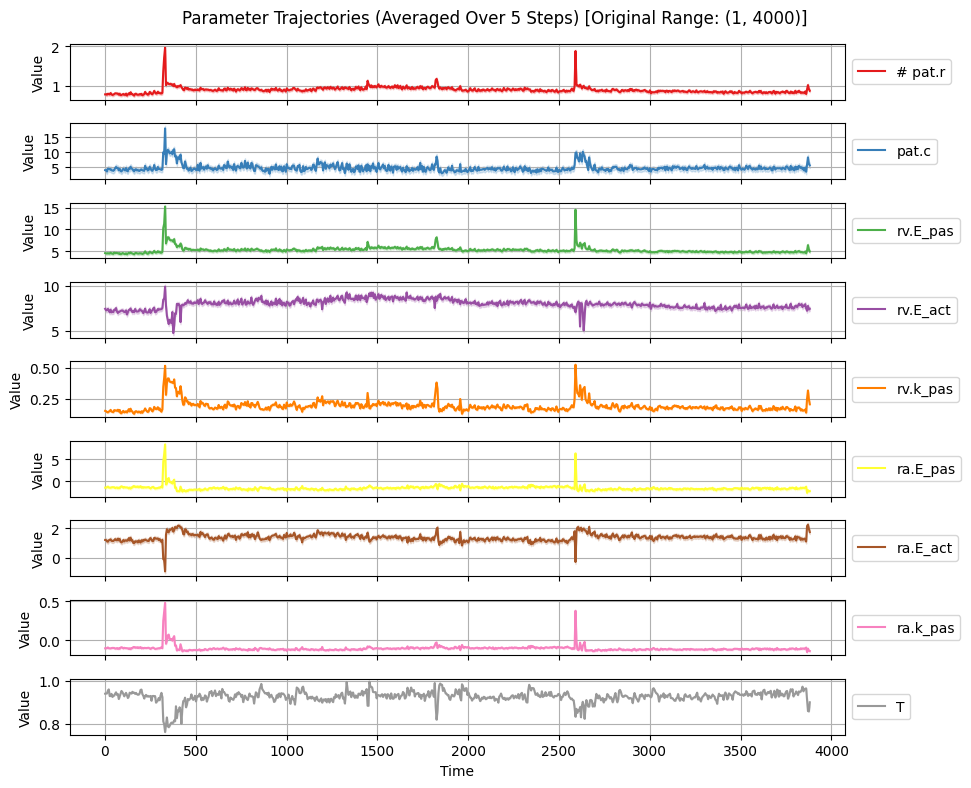

In [18]:
import numpy as np
import matplotlib.pyplot as plt

class ResolutionController:
    def __init__(self, window_size):
        self.window_size = window_size

    def downsample(self, data):
        """Downsamples the data by averaging over non-overlapping windows."""
        if data.shape[0] < self.window_size:
            raise ValueError(f"Data has fewer than {self.window_size} time steps!")

        num_windows = data.shape[0] // self.window_size  # Compute number of full windows
        return data[:num_windows * self.window_size].reshape(num_windows, self.window_size, -1).mean(axis=1)

# Initialize resolution controller
window_size = 5
res_controller = ResolutionController(window_size)

# Define time range before downsampling
time_range = (1, 4000)  # Specify the indices from the original data

# Ensure posterior_variances has shape (3888, p)
posterior_variances_corrected = np.array(Sigma_post).diagonal().reshape(1, -1)  # (1, p)
posterior_variances_corrected = np.tile(posterior_variances_corrected, (posterior_means.shape[0], 1))  # (3888, p)


# Slice the original data before downsampling
posterior_means_trimmed = posterior_means[time_range[0]:time_range[1]]
posterior_variances_trimmed = posterior_variances_corrected[time_range[0]:time_range[1]]

# Downsample the sliced data
posterior_means_smooth = res_controller.downsample(posterior_means_trimmed)  # (new_length, p)
posterior_variances_smooth = res_controller.downsample(np.sqrt(posterior_variances_trimmed))  # (new_length, p)


# Generate new time indices based on downsampling
T_smooth = np.arange(posterior_means_smooth.shape[0]) * window_size + time_range[0]

# Colors for different parameters
param_names = bc.param_names
colors = plt.cm.get_cmap('Set1', len(param_names)).colors

# Plot each parameter on a separate subplot
fig, axes = plt.subplots(len(param_names), 1, figsize=(10, 8), sharex=True)

for i in range(len(param_names)):
    mean = posterior_means_smooth[:, i]  # Smoothed mean
    std_dev = posterior_variances_smooth[:, i]  # Smoothed standard deviation

    axes[i].plot(T_smooth, mean, color=colors[i], label=param_names[i])
    axes[i].fill_between(T_smooth, mean - 2 * std_dev, mean + 2 * std_dev, color=colors[i], alpha=0.2)

    axes[i].set_ylabel('Value')
    axes[i].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    axes[i].grid()

axes[-1].set_xlabel('Time')
fig.suptitle(f'Parameter Trajectories (Averaged Over {window_size} Steps) [Original Range: {time_range}]')

plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make space for legends on the right
plt.show()